# GPT as a Sentiment Analysis Classifier

Sentiment analysis is the process of determining the emotional tone behind a body of text. This is a common task in the fields of data analysis, customer feedback, and social media monitoring, where understanding public opinion or consumer sentiment is valuable. LLMs like GPT are trained on vast amounts of text data, which enables them to “understand” and generate human-like text. We will try out different kinds of prompting to carry out this task. 

# Analyzing the Data Set

To test the capabilities of GPT in the sentiment classification task, we used the following data set, which contains reviews of hotels Trip Advisor. It contains reviews of hotels and the rating given from 1-5, and considered the following classification:

- Rating 1-2 → “negative”
- Rating 3 → “neutral”
- Rating 4-5 → “positive”

https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews

In [1]:
import pandas as pd
df=pd.read_csv('../Data/tripadvisor_hotel_reviews.csv')
df

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1


In [3]:
#create labels
print(df['Rating'].value_counts())
df.loc[df['Rating']<3,'class']='negative'
df.loc[df['Rating']==3,'class']='neutral'
df.loc[df['Rating']>=4,'class']='positive'
df

Rating
5    9054
4    6039
3    2184
2    1793
1    1421
Name: count, dtype: int64


,Review,Rating,class
0,nice hotel expensive parking got good deal sta...,4,positive
1,ok nothing special charge diamond member hilto...,2,negative
2,nice rooms not 4* experience hotel monaco seat...,3,neutral
3,"unique, great stay, wonderful time hotel monac...",5,positive
4,"great stay great stay, went seahawk game aweso...",5,positive
...,...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5,positive
20487,great location price view hotel great quick pl...,4,positive
20488,"ok just looks nice modern outside, desk staff ...",2,negative
20489,hotel theft ruined vacation hotel opened sept ...,1,negative


In [10]:
"""Create a small data set for experiments, since using the whole thing is very expensive both time
and money wise"""
pos_df = df[df['class']=='positive']
neg_df = df[df['class']=='negative']
neu_df = df[df['class']=='neutral']

#pos_df = pos_df.reset_index(drop=True)
#neg_df = neg_df.reset_index(drop=True)
#neu_df = neu_df.reset_index(drop=True)

pos_df = pos_df.reset_index()
neg_df = neg_df.reset_index()
neu_df = neu_df.reset_index()

pos_df = pos_df.loc[:100]
neg_df = neg_df.loc[:100]
neu_df = neu_df.loc[:100]

test_df = pd.concat([pos_df, neg_df, neu_df], axis=0, ignore_index=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df.to_csv('../Data/test_data.csv', index=False)


train_df = df.drop(test_df['index'])
train_df = train_df.sample(frac=1, random_state=42).reset_index()
train_df.to_csv('../Data/train_data.csv', index=False)

print(test_df.shape)
print(train_df.shape)

(303, 4)
(20188, 4)


# Comparing Prompting techniques

LLMs are neural networks with a transformer architecture trained to do autoregression (predicting the next word after a sequence). They are trained over a large corpus of texts that include the Wikipedia, Internet scrapping, news articles, code and other sources. Furthermore, they are instruction-tuned in a second learning phase to output satisfactory responses to human instructions. Due to this nature, we can skillfully craft prompts or inputs to bias the behavior of AI models, particularly language models like GPT-4. This is called prompt engineering. The goal is to optimize the AI's response for accuracy, creativity, or specific outcomes. 

In the following section, we will try different prompting techniques to try and optimize our classifier. We used test data set which contained 100 examples of each class.


In [2]:
test_df = pd.read_csv('../Data/test_data.csv')

## Some functions

In [5]:
from openai import OpenAI
client = OpenAI()

#Zero shot predict function with different parameters
def zero_shot_predict(review,model='gpt-3.5-turbo',explanation=False, confidence = False, role = 'helpful assistant', client=client):
    if explanation == True:
        if confidence == True:
            conf_level = 'Confidence Level: <confidence_level>'
            extra_instr = 'giving a confidence level on the prediction from (low, medium, high)'
        else:
            conf_level = ''
            extra_instr = ''
        instruction = """Explain the reasoning behind the classification step by step briefly and classify the review {extra} as follows:
        Reasoning: <reasoning>
        Class: <class>
        {conf}
        """.format(extra = extra_instr, conf = conf_level)
    else:
        if confidence == True:
            instruction = """Classify the review and give a confidence level on the prediction from (low, medium, high) as follows:
            Class: <class>
            Confidence Level: <confidence_level>
            """
        else:
            instruction = "Do it as follows: Class: <class>"

    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": "You are a" + role  + " who has to label reviews as 'positive', 'neutral' or 'negative'. " + instruction,
            },
            
            {
                "role": "user",
                "content": review,
            }
        ],
        model=model,
    )
    return chat_completion.choices[0].message.content


#Zero shot predict function with different parameters
def one_shot_predict(review, model='gpt-3.5-turbo', explanation=False, confidence = False, role = 'helpful assistant' ,client=client):

    if explanation == True:
        if confidence == True:
            conf_level = 'Confidence Level: <confidence_level>'
            extra_instr = 'giving a confidence level on the prediction from (low, medium, high)'
            conf_pos = '\n Confidence Level: high'
            conf_neg = '\n Confidence Level: high'
            conf_nt = '\n Confidence Level: medium'
        else:
            conf_level = ''
            extra_instr = ''
            conf_pos = ''
            conf_neg = ''
            conf_nt = ''
        instruction = """Explain the reasoning behind the classification briefly and classify the review {extra} as follows:
        Reasoning: <reasoning>
        Class: <class>
        {conf}
        """.format(extra = extra_instr, conf = conf_level)

        positive_explanation = """Reasoning: The reviewer highlights several positive aspects of their stay at Hotel Monaco. 
        They mention that the reception staff was friendly and professional, and they enjoyed the smart and comfortable room with a comfortable bed. 
        The reviewer also mentions that they particularly liked the fact that the reception staff was friendly towards a small dog and that the staff and 
        guests spoke and loved the dog. Although there is a mild negative aspect mentioned, which is the distance uphill to the local market and restaurants, 
        the overall tone of the review remains positive. The reviewer states that they had a great experience at the hotel, indicating that the positive elements outweigh the negative one.
        \n Class: positive""" + conf_pos


        negative_explanation = """"'Reasoning: The review highlights several negative aspects of the hotel experience.
        The customer encountered issues with their booking request for a nonsmoking room with a king bed away from the elevator and ice. 
        The front desk staff was rude and did not honor the special requests noted on the reservation card. They were given a room with two double beds located directly across from the elevator and ice machine. 
        The hotel parking garage was dirty, and there was a smell of urine in the hotel lobby. The carpets in the registration and elevator area were dirty, 
        and the upholstery and curtains in the room were also in need of cleaning. The bathroom had issues with water conservation, with the tub facet constantly dripping and the shower curtain having holes. 
        There was no coffee maker in the room, and the bedding did not fit the bed properly. The staff, except for the housekeeping staff, were described as unfriendly and short. 
        Overall, the review indicates a negative experience at the hotel.
        \n Class: negative'
        """ + conf_neg
        neutral_explanation = """"Reasoning: the review contains both positive and negative elements. 
        On one hand, it highlights the excellent location of the hotel, mentioning its proximity to Pike Market and great restaurants. 
        On the other hand, it criticizes the quality of the hotel, comparing it unfavorably to others and pointing out several issues. 
        This mix of positive and negative aspects can lead to a neutral overall sentiment.
        The language used in the review is relatively moderate. It doesn't use strong positive words (like "amazing" or "fantastic") or strongly negative words (like "horrible" or "terrible"). The reviewer states facts and observations without strong emotional emphasis.  
        The reviewer lists specific issues (like no desks in rooms, worn furniture coverings, and the type of air conditioning) but does so in a factual manner without exaggeration.
        \nClass: neutral
        """ + conf_nt
    else:
        if confidence == True:
            instruction = """Classify the review and give a confidence level on the prediction from (low, medium, high) as follows:
            Class: <class>
            Confidence Level: <confidence_level>
            """
            conf_pos = '\n Confidence Level: high'
            conf_neg = '\n Confidence Level: high'
            conf_nt = '\n Confidence Level: medium'
        else:
            instruction = "Do it as follows: Class: <class>"
            conf_pos = ''
            conf_neg = ''
            conf_nt = ''
        positive_explanation = 'Class: positive' + conf_pos
        negative_explanation = 'Class: negative' + conf_neg
        neutral_explanation = 'Class: neutral' + conf_nt

    good_review="""excellent stayed hotel monaco past w/e delight, reception staff friendly professional room smart comfortable bed, 
    particularly liked reception small dog received staff guests spoke loved, 
    mild negative distance uphill ppmarket restaurants 1st, overall great experience,  '"""

    bad_review = """bad choice, booked hotel hot wire called immediately requesting nonsmoking room king bed room away elevator/ice.
    the person spoke pleasant stated not guarantee requests honored make note reservation, check-in person desk rude said no special 
    request noted reservation card andstated no king beds way reservation stuck 2 double beds, located directly accross elevator ice, 
    nonsmoking, no elevator parking garage hotel, warwick mats garage filthy stairwells, hotel faces 4th smells urine, carpets registration elevator area need cleaning, 
    upholstery curtains room needed cleaning andpressing sign bathroom water conservation tub facet dripped continuously, tub drain needsattention shower curtain holes, 
    no coffee maker room, bedding did not fit bed sleeping directly mattress bedding askew, staff unfriendly short, 
    housekeeping staff quite pleasant, stay hotel, """

    neutral_review="""expensive, not biz travellers, simple fact hotel location simply unbeatable.. 
    mere stone throw away pike market, plenty great restaurants generally fun area, tourist, quality hotel so-so, 
    not place business travellers, bit hard especially just returned trip hk stayed conrad hk wynn macau, 
    compared inn feels like motel 6. issues:1. no desks rooms place laptops, wireless internet no place work bed,
      2. furniture coverings worned just outdated, 3. ac standalone unit attached wall, not central, 
    standalone unit quite bit noise, looks cheap tacky"""

    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": "You are a" + role + " who has to label reviews as 'positive', 'neutral'  or 'negative'." + instruction,
            },
            
            {
                "role": "user",
                "content": good_review,
            },

            {
                "role": "assistant",
                "content": positive_explanation,
            },

            {
                "role": "user",
                "content": neutral_review,
            },

            {
                "role": "assistant",
                "content": neutral_explanation ,
            },    
            
            {
                "role": "user",
                "content": bad_review,
            },
            
            {
                "role": "assistant",
                "content": negative_explanation,
            },

            {
                "role": "user",
                "content": review,
            },
        ],
        model = model,
    )
    return chat_completion.choices[0].message.content

In [13]:
#General prompt function where you can select zero or few shot strategy
def prompting(review, iterations = 1, shots = 'zero',  model='gpt-3.5-turbo', explanation=False, confidence = False, role = 'helpful assistant' ,client=client ):
    results = []
    if shots == 'few':
        predicting_function = one_shot_predict
    elif shots == 'zero':
        predicting_function = zero_shot_predict
    else:
        print('strategy not valid')
        return None

    for i in range(iterations):
        output = predicting_function(review=review, model=model, explanation=explanation,confidence = confidence, role=role, client = client )
        results.append(output)
    return results

#function to deal with the output of the API
def extract_from_output(output, to_extract = 'class'):
    # Split the output into lines
    lines = output.split('\n')

    # Search for the line that contains 'Class'
    if to_extract == 'reasoning':
        line_start = 'Reasoning'
    elif to_extract == 'confidence_level':
        line_start = 'Confidence Level'
    elif to_extract == 'class':
        line_start = 'Class'
    else:
        print('Not a part of the output')
        return None
    for line in lines:
        if line.startswith(line_start):
            # Split the line into 'Class' and the actual class value
            _, value = line.split(': ')
            return value.strip().lower()

#Give a df returns the df with predictions column (and confidence)
def predict_df(df, reviews_column, iterations = 1, shots = 'zero',  model='gpt-3.5-turbo', explanation=False, confidence = False, role = 'helpful assistant' ,client=client):
    df_copy=df.copy()
    # Apply the prompting function
    predictions = df_copy[reviews_column].apply(lambda x: prompting(x, iterations=iterations, shots=shots, model=model, explanation=explanation, confidence=confidence, role=role, client=client))
    if confidence == True:
        # Iterate through each prediction and apply extract_class_confidence
        for i in range(iterations):
            # Assuming extract_class_confidence returns a single value or a tuple, adapt accordingly
            df_copy['prediction_' + str(i)] = predictions.apply(lambda x: extract_from_output(x[i], 'class'))
            df_copy['confidence_'+ str(i)] = predictions.apply(lambda x: extract_from_output(x[i], 'confidence_level'))

    else:
        # Iterate through each prediction and apply extract_class_confidence
        for i in range(iterations):
            # Assuming extract_class_confidence returns a single value or a tuple, adapt accordingly
            df_copy['prediction_' + str(i)] = predictions.apply(lambda x: extract_from_output(x[i], 'class'))
    
    save_string = './predictions/predictions_' + str(iterations) + '_' + str(shots) + '_' + str(model) + '_' + 'ChOT'+ '_' + str(explanation) + '_conf'+ '_' + str(confidence) + '_' + str(role) + '.csv'
    print('Saved: ',save_string)
    df_copy.to_csv(save_string)  

In [6]:
import pandas as pd
#reading the predictions we made
def read_file(iterations = 1, shots = 'zero',  model='gpt-3.5-turbo', explanation=False, confidence = True, role = 'helpful assistant'):
    file_name = './predictions/predictions_' + str(iterations) + '_' + str(shots) + '_' + str(model) + '_' + 'ChOT'+ '_' + str(explanation) + '_conf'+ '_' + str(confidence) + '_' + str(role) + '.csv'
    df=pd.read_csv(file_name)
    print(df.shape)
    return df

In [7]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
def get_results_df(df,prediction_column):
    #We will put everything in lower cases
    df[prediction_column]=df[prediction_column].str.lower()

    #we will drop rows where something wierd was predicted
    df = df[df[prediction_column].isin(['positive', 'negative', 'neutral'])]

    #create vectors with predictions
    df['pred_-']=0
    df['pred_n']=0
    df['pred_+']=0


    df['class_-']=0
    df['class_n']=0
    df['class_+']=0

    df.loc[df['class']=='positive','class_+']=1
    df.loc[df['class']=='negative','class_-']=1
    df.loc[df['class']=='neutral','class_n']=1

    df.loc[df[prediction_column]=='positive','pred_+']=1
    df.loc[df[prediction_column]=='negative','pred_-']=1
    df.loc[df[prediction_column]=='neutral','pred_n']=1

    y=df[['class_-', 'class_n','class_+']].values
    y_hat=df[['pred_-', 'pred_n','pred_+']].values


    #Calculate Accuracy
    accuracy = 1-np.sum(np.linalg.norm((y-y_hat),axis=1))/y.shape[0]
    print('Accuracy: ',accuracy)
    report = classification_report(y_hat, y)
    print(report)
    return df, accuracy,report

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_results_df(df, predictions_column):
    # Assuming you have a DataFrame named df with columns 'column1' and 'column2'

    # Group by 'column_5_classes' and 'column_3_classes', then count the occurrences
    grouped_df = df.groupby(['Rating', predictions_column]).size().unstack(fill_value=0)

    # Plot the grouped bar chart
    ax = grouped_df.plot(kind='bar', figsize=(10, 6), stacked=False)

    # Add labels and title
    plt.xlabel('Star Rating')
    plt.ylabel('Count')
    plt.title('Classification')

    # Show the plot
    plt.show()

In [11]:
def plot_confidence(df,confidence_column):
    df['classification'] = ((df['class_-'] == df['pred_-']) &
                        (df['class_+'] == df['pred_+']) &
                        (df['class_n'] == df['pred_n']))
        # Assuming you have a DataFrame named df with columns 'column1' and 'column2'
    df[confidence_column] = df[confidence_column].str.replace("'","")
    df[confidence_column] = df[confidence_column].str.replace('"',"")
    # Group by 'column_5_classes' and 'column_3_classes', then count the occurrences
    grouped_df = df.groupby(['classification', confidence_column]).size().unstack(fill_value=0)

    # Plot the grouped bar chart
    ax = grouped_df.plot(kind='bar', figsize=(10, 6), stacked=False)

    # Add labels and title
    plt.xlabel('Classification')
    plt.ylabel('Count')
    plt.title('Classification and Confidence')

    # Show the plot
    plt.show()

In [9]:
import re
def extract_f1_scores(classification_report):
    # Regular expression to match lines with class scores
    # This regex looks for lines that start with a number (class label) and captures the f1-score
    pattern = r'^\s*\d+\s+\S+\s+\S+\s+(\S+)'

    # Find all matches
    f1_scores = re.findall(pattern, classification_report, re.MULTILINE)

    # Convert the scores to float
    f1_scores = [float(score) for score in f1_scores]

    return f1_scores

In [10]:
# Define a function to get the most common prediction
def most_common_prediction(row):
    predictions = [row['prediction_0'], row['prediction_1'], row['prediction_2']]
    return pd.Series(predictions).mode()[0]

def most_common_confidence(row):
    confidences = [row['confidence_0'], row['confidence_1'], row['confidence_2']]
    return pd.Series(confidences).mode()[0]

## Zero shot

In zero-shot learning, the model is asked to perform a task that it has not explicitly been trained on. It does this based on the knowledge it has already acquired during its initial training. In this case, we are asking GPT-3.5, which was trained on a wide range of texts, to classify the sentiment of a sentence without it having ever been specifically trained on sentiment analysis. The model uses its general understanding of language to infer the sentiment. 

In [16]:
#Example
review = """'shame hotel wasnt good restaurant, arrived clift late afternoon struggle luggage 3 bags, 
reception staff unhelpful uninterested, eventually managed sorted shown room 9th floor, 
room suite tried make separate living room putting curtain inbetween bedroom living room, bathroom tiny dirty, 
stayed mum unfortunatley night didnt feel suffering bad foot, decided phone reception ask doctor come hotel told 
ther wasnt local receptionist closest told phone, eventually decided hospital just safe, 
came hospital evening doormen talking girls outside let, following night ate hotel restaurant aisa cuba fantastic, 
think hotel intrest restaurant bar, end day sleeping ignored wouldnt stay,'"""

print(prompting(review, iterations = 1, shots = 'zero',  model='gpt-3.5-turbo', explanation=False, confidence = True, role = 'helpful assistant' ,client=client )[0])

Class: negative
Confidence Level: high


In [ ]:
predict_df(test_df, 'Review', iterations = 1, shots = 'zero',  model='gpt-3.5-turbo', explanation=False, confidence = True, role = 'helpful assistant' ,client=client)

(303, 6)
Accuracy:  0.5659344511528125
              precision    recall  f1-score   support

           0       0.94      0.69      0.80       137
           1       0.22      0.69      0.33        32
           2       0.92      0.69      0.79       134

   micro avg       0.69      0.69      0.69       303
   macro avg       0.69      0.69      0.64       303
weighted avg       0.86      0.69      0.75       303
 samples avg       0.69      0.69      0.69       303



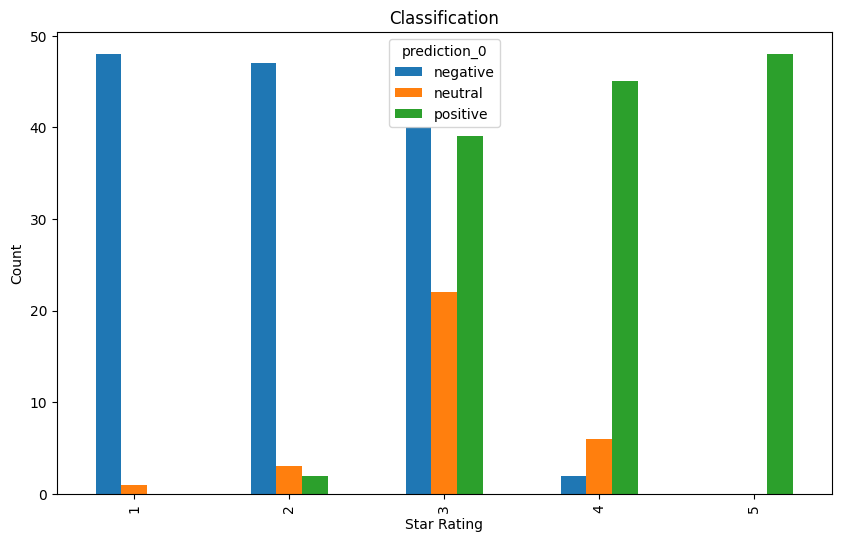

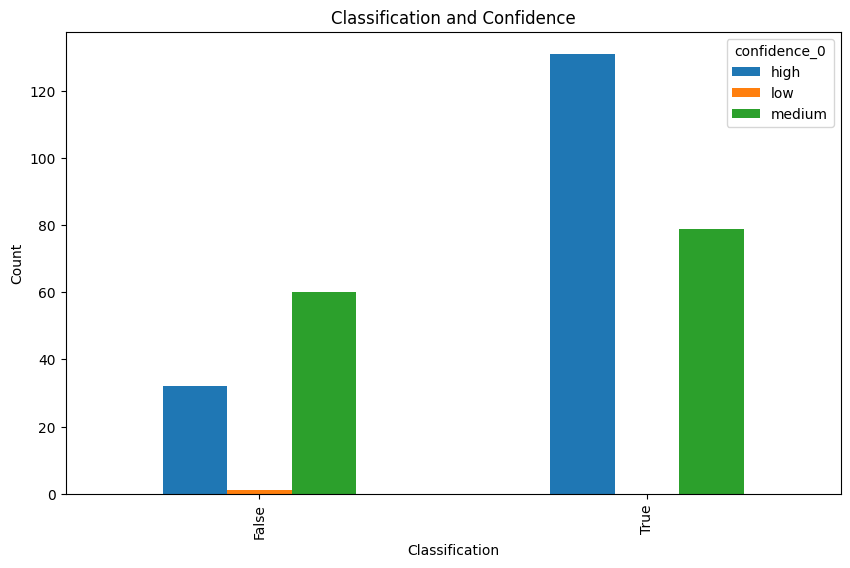

In [11]:
df1 = read_file(iterations = 1, shots = 'zero',  model='gpt-3.5-turbo', explanation=False, confidence = True, role = 'helpful assistant')
df1, acc1, r1 = get_results_df(df1,'prediction_0')
plot_results_df(df1,'prediction_0')
plot_confidence(df1,'confidence_0')

## Zero Shot + Expert

By default, GPT acts as a 'helpful assistant'. We can bias the responses of the model by defining its role as being an expert in the field of the particular task we want it to perform. In this case, we will tell him that it is a 'expert hotelier'. We can see that perormance slightly improves.

In [17]:
#Example
review = """'shame hotel wasnt good restaurant, arrived clift late afternoon struggle luggage 3 bags, 
reception staff unhelpful uninterested, eventually managed sorted shown room 9th floor, 
room suite tried make separate living room putting curtain inbetween bedroom living room, bathroom tiny dirty, 
stayed mum unfortunatley night didnt feel suffering bad foot, decided phone reception ask doctor come hotel told 
ther wasnt local receptionist closest told phone, eventually decided hospital just safe, 
came hospital evening doormen talking girls outside let, following night ate hotel restaurant aisa cuba fantastic, 
think hotel intrest restaurant bar, end day sleeping ignored wouldnt stay,'"""

print(prompting(review, iterations = 1, shots = 'zero',  model='gpt-3.5-turbo', explanation=False, confidence = True, role = 'expert hotelier' ,client=client )[0])

Class: Negative
Confidence Level: Medium


In [ ]:
predict_df(test_df, 'Review', iterations = 1, shots = 'zero',  model='gpt-3.5-turbo', explanation=False, confidence = True, role = 'expert hotelier' ,client=client)

(303, 6)
Accuracy:  0.5752691941387733
              precision    recall  f1-score   support

           0       0.94      0.70      0.81       135
           1       0.20      0.83      0.32        24
           2       0.96      0.67      0.79       144

   micro avg       0.70      0.70      0.70       303
   macro avg       0.70      0.74      0.64       303
weighted avg       0.89      0.70      0.76       303
 samples avg       0.70      0.70      0.70       303



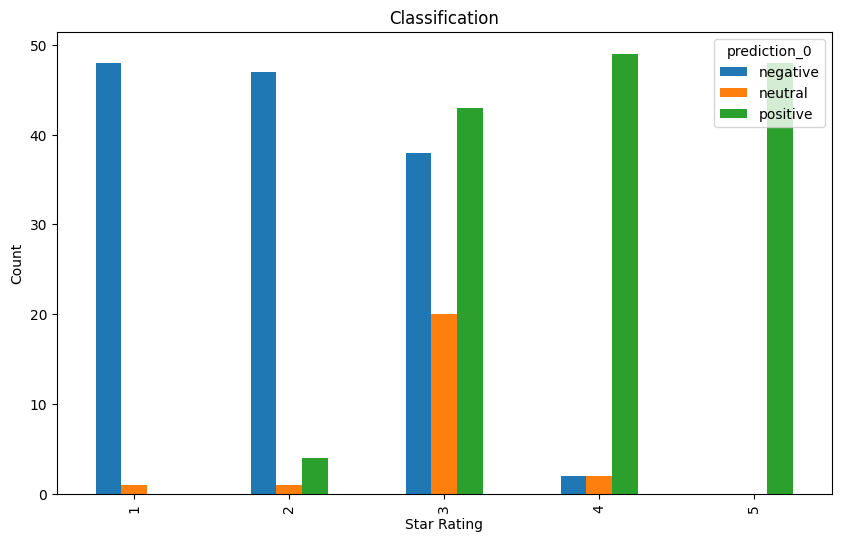

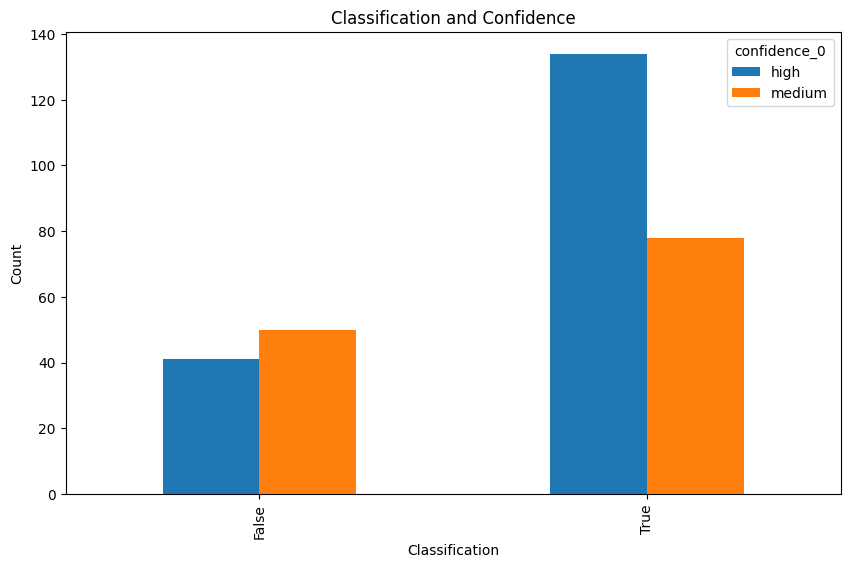

In [8]:
df2 = read_file(iterations = 1, shots = 'zero',  model='gpt-3.5-turbo', explanation=False, confidence = True, role = 'expert hotelier')
df2, acc2, r2 = get_results_df(df2,'prediction_0')
plot_results_df(df2,'prediction_0')
plot_confidence(df2,'confidence_0')

## Zero Shot + Expert + CoT

The following technique we added is "Chain of Thought" (CoT). CoT consist in asking the model to perform the task step by step and "reason" all the way to the final result. In our case, the model will give reasons on why the review is positive or negative, biasing the final classification, since as we said, LLMs predict the next work given the previous input. 

A secondary benefit from this approach is that providing reasoning behind classifications can increase transparency and build trust. When users understand why a model classifies a text in a certain way, they are more likely to trust and accept its conclusions, especially in cases where the sentiment analysis might not be straightforward.

**Limitations and Considerations**:
It's important to note that the "reasoning" provided by an LLM is an approximation based on patterns the model has learned during training. The model doesn't "understand" in the human sense but rather generates plausible explanations based on its training data. The explanations generated by an LLM might not always accurately reflect the true reasoning behind its classification. They should be understood as best guesses based on the model's training, not as definitive insights into the model's thought process.

In [18]:
#Example
review = """'shame hotel wasnt good restaurant, arrived clift late afternoon struggle luggage 3 bags, 
reception staff unhelpful uninterested, eventually managed sorted shown room 9th floor, 
room suite tried make separate living room putting curtain inbetween bedroom living room, bathroom tiny dirty, 
stayed mum unfortunatley night didnt feel suffering bad foot, decided phone reception ask doctor come hotel told 
ther wasnt local receptionist closest told phone, eventually decided hospital just safe, 
came hospital evening doormen talking girls outside let, following night ate hotel restaurant aisa cuba fantastic, 
think hotel intrest restaurant bar, end day sleeping ignored wouldnt stay,'"""

print(prompting(review, iterations = 1, shots = 'zero',  model='gpt-3.5-turbo', explanation=True, confidence = True, role = 'expert hotelier' ,client=client )[0])

Reasoning: The review mentions several negative aspects of the hotel, such as unhelpful staff, dirty room and bathroom, and a lack of concern for guest's well-being. However, the review also mentions a positive experience at the hotel restaurant. 

Class: Negative

Confidence Level: Medium


In [ ]:
predict_df(test_df, 'Review', iterations = 1, shots = 'zero',  model='gpt-3.5-turbo', explanation=True, confidence = True, role = 'expert hotelier' ,client=client)

(303, 6)
Accuracy:  0.6168852891230077
              precision    recall  f1-score   support

           0       0.96      0.74      0.83       129
           1       0.35      0.71      0.47        49
           2       0.87      0.73      0.79       121

   micro avg       0.73      0.73      0.73       299
   macro avg       0.73      0.73      0.70       299
weighted avg       0.82      0.73      0.76       299
 samples avg       0.73      0.73      0.73       299



C:\Users\afred\AppData\Local\Temp\ipykernel_16088\2939891079.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_-']=0
C:\Users\afred\AppData\Local\Temp\ipykernel_16088\2939891079.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_n']=0
C:\Users\afred\AppData\Local\Temp\ipykernel_16088\2939891079.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

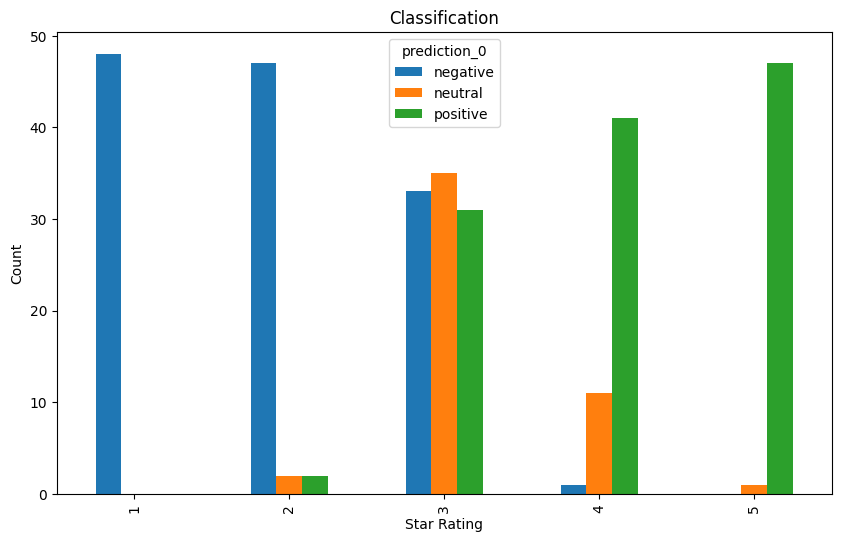

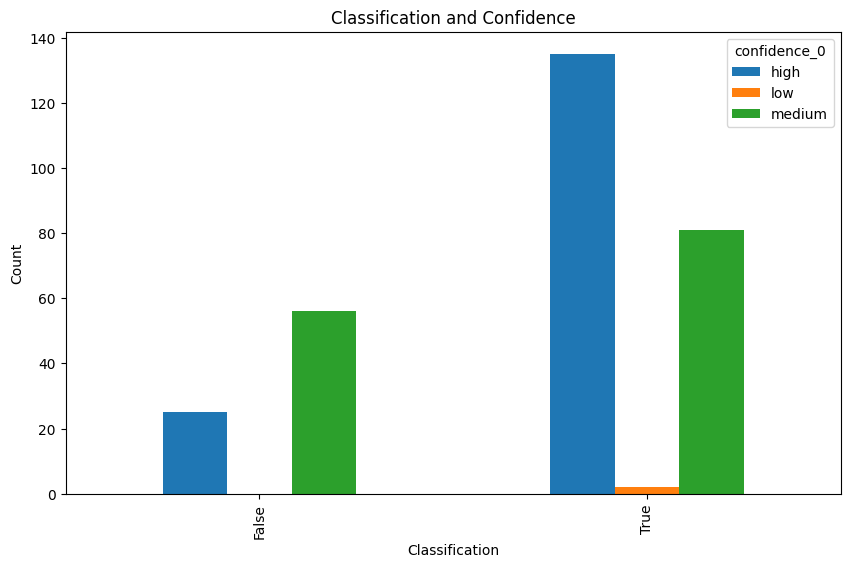

In [9]:
df3 = read_file(iterations = 1, shots = 'zero',  model='gpt-3.5-turbo', explanation=True, confidence = True, role = 'expert hotelier')
df3,acc3, r3 = get_results_df(df3,'prediction_0')
plot_results_df(df3,'prediction_0')
plot_confidence(df3,'confidence_0')

## Few Shot + Expert + CoT

Few-shot learning involves giving the model a small number of examples (or "shots") of the task at hand, from which it can quickly learn and adapt. We will give GPT three examples of text along with their sentiment classifications, in hopes of getting better outputs. The model then uses these examples to better understand and perform the sentiment analysis task. This approach can improve the model's accuracy on specific tasks without requiring extensive retraining.

In [19]:
#Example
review = """'shame hotel wasnt good restaurant, arrived clift late afternoon struggle luggage 3 bags, 
reception staff unhelpful uninterested, eventually managed sorted shown room 9th floor, 
room suite tried make separate living room putting curtain inbetween bedroom living room, bathroom tiny dirty, 
stayed mum unfortunatley night didnt feel suffering bad foot, decided phone reception ask doctor come hotel told 
ther wasnt local receptionist closest told phone, eventually decided hospital just safe, 
came hospital evening doormen talking girls outside let, following night ate hotel restaurant aisa cuba fantastic, 
think hotel intrest restaurant bar, end day sleeping ignored wouldnt stay,'"""

print(prompting(review, iterations = 1, shots = 'few',  model='gpt-3.5-turbo', explanation=True, confidence = True, role = 'expert hotelier' ,client=client )[0])

Reasoning: The review presents a negative experience at the hotel. 
        The reviewer mentions struggling with their luggage upon arrival and describes the reception staff as unhelpful and uninterested. 
        They were eventually shown to a room on the 9th floor, where they found issues such as a small and dirty bathroom and a makeshift separation between the living room and bedroom. 
        The reviewer also mentions experiencing a foot problem and attempting to seek medical assistance from the hotel, but receiving unhelpful responses. 
        They ended up going to a hospital instead. 
        However, the reviewer does mention the positive experience of dining at the hotel restaurant on one occasion.
        
Class: negative
        
Confidence Level: medium


In [ ]:
predict_df(test_df, 'Review', iterations = 1, shots = 'few',  model='gpt-3.5-turbo', explanation=True, confidence = True, role = 'expert hotelier' ,client=client)

(303, 6)
Accuracy:  0.6594535903315624
              precision    recall  f1-score   support

           0       0.83      0.89      0.86        94
           1       0.48      0.73      0.58        64
           2       0.96      0.68      0.80       141

   micro avg       0.76      0.76      0.76       299
   macro avg       0.76      0.77      0.75       299
weighted avg       0.82      0.76      0.77       299
 samples avg       0.76      0.76      0.76       299



C:\Users\afred\AppData\Local\Temp\ipykernel_16088\2939891079.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_-']=0
C:\Users\afred\AppData\Local\Temp\ipykernel_16088\2939891079.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_n']=0
C:\Users\afred\AppData\Local\Temp\ipykernel_16088\2939891079.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

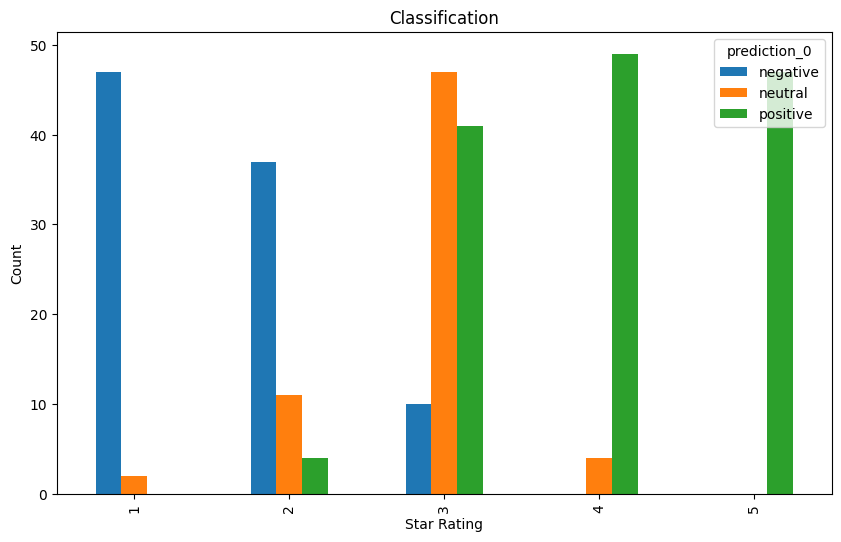

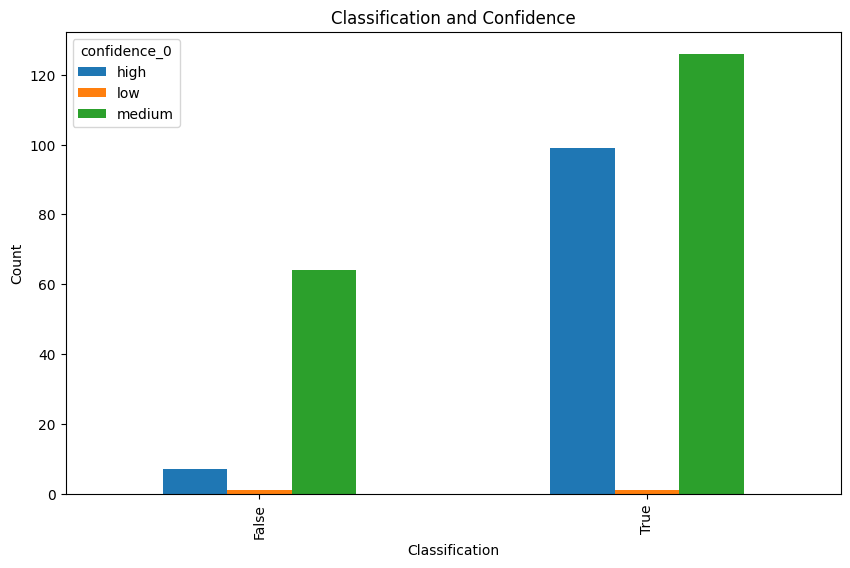

In [10]:
df4 = read_file(iterations = 1, shots = 'few',  model='gpt-3.5-turbo', explanation=True, confidence = True, role = 'expert hotelier')
df4, acc4, r4 = get_results_df(df4,'prediction_0')
plot_results_df(df4,'prediction_0')
plot_confidence(df4,'confidence_0')

## Few Shot + Expert + CoT + Autoconsistency

We have mentioned that LLMs are probabilistic predictors of the next word. Therefore, there could be cases were probability of choosing one class or another are similar. A way to go around this problem is using autoconsistency. This method consists on repeating the request several times and keeping the most common answer. In our case, we did 3 iterations and got better results.

In [20]:
#Example
review = """'shame hotel wasnt good restaurant, arrived clift late afternoon struggle luggage 3 bags, 
reception staff unhelpful uninterested, eventually managed sorted shown room 9th floor, 
room suite tried make separate living room putting curtain inbetween bedroom living room, bathroom tiny dirty, 
stayed mum unfortunatley night didnt feel suffering bad foot, decided phone reception ask doctor come hotel told 
ther wasnt local receptionist closest told phone, eventually decided hospital just safe, 
came hospital evening doormen talking girls outside let, following night ate hotel restaurant aisa cuba fantastic, 
think hotel intrest restaurant bar, end day sleeping ignored wouldnt stay,'"""
result = prompting(review, iterations = 3, shots = 'few',  model='gpt-3.5-turbo', explanation=True, confidence = True, role = 'expert hotelier' ,client=client )
print(result[0], '\n\n', result[1], '\n\n',result[2])


Reasoning: The review describes a negative experience at the hotel. 
        The review mentions struggling with luggage upon arrival and unhelpful and uninterested reception staff. 
        The room had issues, such as attempting to separate the living room with a curtain and a bathroom that was described as tiny and dirty. 
        The reviewer also mentions a personal health issue and their disappointment with the hotel's lack of assistance in finding a doctor. 
        The positive aspect mentioned is the fantastic experience at the hotel restaurant, but it is overshadowed by the negative experience at the hotel itself.
        
Class: negative

Confidence Level: high 

 Reasoning: The review contains both positive and negative aspects. 
        The reviewer mentions struggling with their luggage upon arrival and describes the reception staff as unhelpful and uninterested. 
        They were eventually shown to a room on the 9th floor, which they tried to make into a separate livin

In [ ]:
#Make predictions
predict_df(test_df, 'Review', iterations = 3, shots = 'few',  model='gpt-3.5-turbo', explanation=True, confidence = True, role = 'expert hotelier' ,client=client)

(303, 10)
Accuracy:  0.6826187384773252
              precision    recall  f1-score   support

           0       0.87      0.89      0.88        99
           1       0.50      0.77      0.60        65
           2       0.96      0.70      0.81       139

   micro avg       0.78      0.78      0.78       303
   macro avg       0.78      0.79      0.76       303
weighted avg       0.83      0.78      0.79       303
 samples avg       0.78      0.78      0.78       303



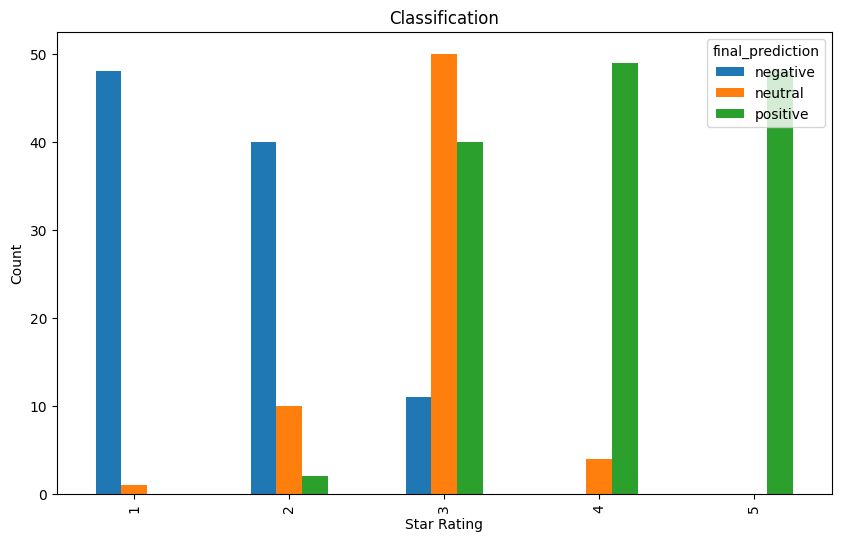

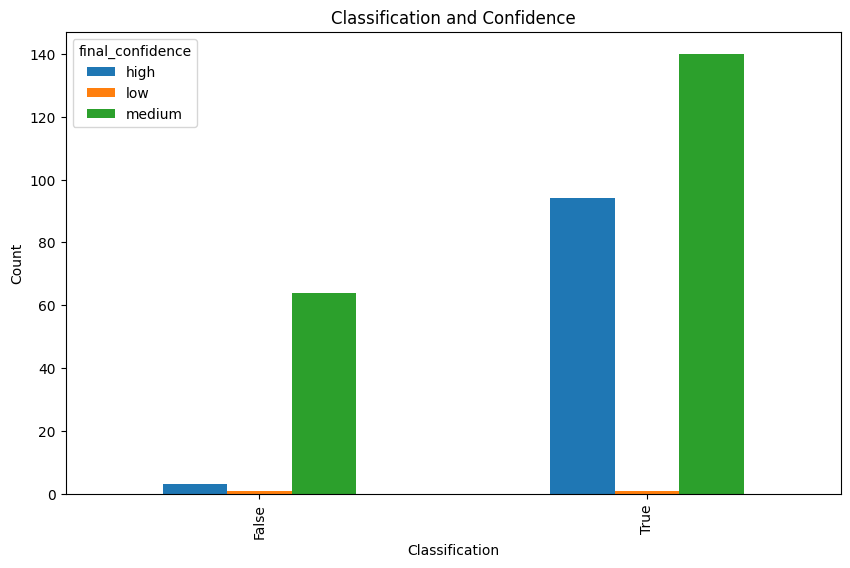

In [11]:
#Analyse the results
df5 = read_file(iterations = 3, shots = 'few',  model='gpt-3.5-turbo', explanation=True, confidence = True, role = 'expert hotelier')
df5['final_prediction'] = df5.apply(most_common_prediction, axis=1)
df5['final_confidence'] = df5.apply(most_common_confidence, axis=1)
df5, acc5, r5 = get_results_df(df5,'final_prediction')
plot_results_df(df5,'final_prediction')
plot_confidence(df5,'final_confidence')


# Comparison
Finally, we will compare the results obtained using the different prompting techniques.

If we plot the accuracy on the test data set for each one of the methods, we can clearly see an improvement.

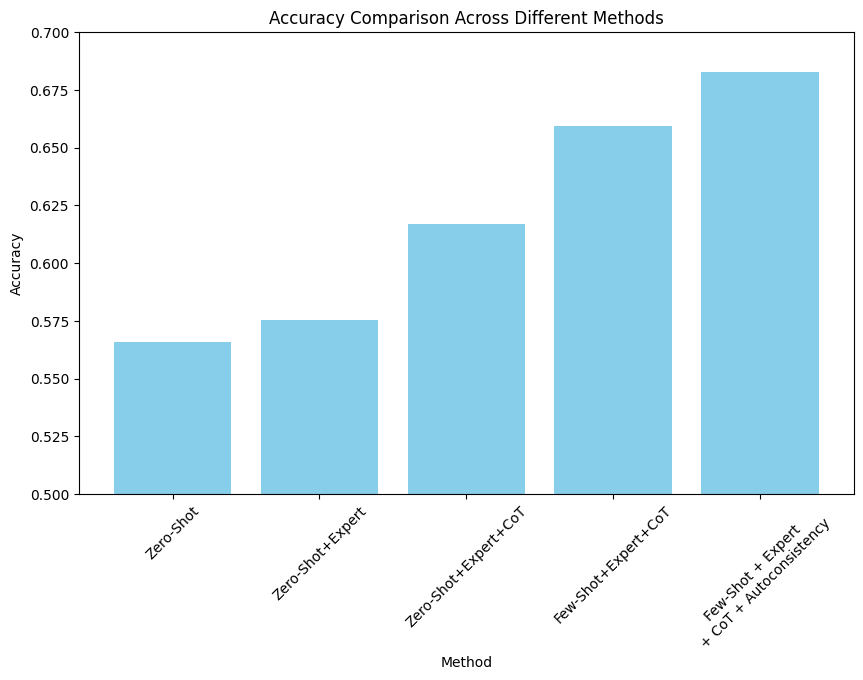

In [12]:
import matplotlib.pyplot as plt

# Labels for the x-axis
labels = ['Zero-Shot', 'Zero-Shot+Expert', 'Zero-Shot+Expert+CoT', 'Few-Shot+Expert+CoT', 'Few-Shot + Expert \n+ CoT + Autoconsistency']

# Values corresponding to each label
accuracies = [acc1, acc2, acc3, acc4, acc5]

# Creating the bar chart
plt.figure(figsize=(10, 6))
plt.bar(labels, accuracies, color='skyblue')
plt.xlabel('Method')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison Across Different Methods')
plt.ylim(0.5, 0.7)  # Assuming accuracy is a percentage between 0 and 1

# Rotate x-axis labels
plt.xticks(rotation=45)  # Rotate labels to 45 degrees

plt.show()


If we plot the f1 score of each one of the classes, we can see that for the positive and negative class, it remains mostly the same, whilst the neutral class, which is the most difficult to predict has a noticeable improvement.

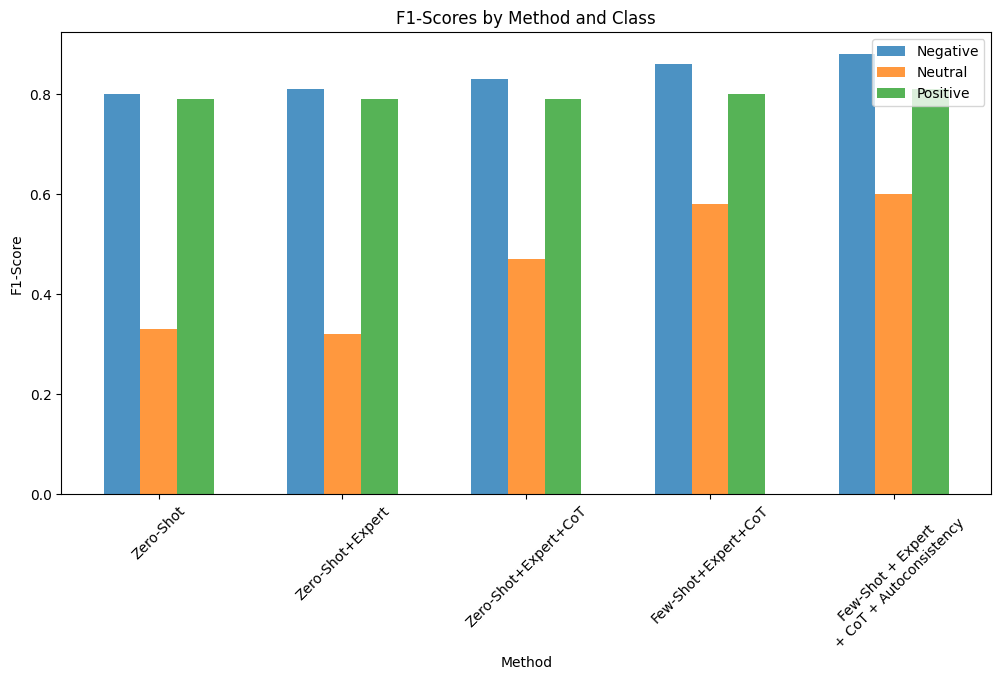

In [13]:
import numpy as np

f1_scores = np.array([extract_f1_scores(r1),extract_f1_scores(r2),extract_f1_scores(r3),extract_f1_scores(r4),extract_f1_scores(r5)])

# Labels for the x-axis
methods = ['Zero-Shot', 'Zero-Shot+Expert', 'Zero-Shot+Expert+CoT', 'Few-Shot+Expert+CoT', 'Few-Shot + Expert \n+ CoT + Autoconsistency']

# Class names (for legend)
classes = ['Negative', 'Neutral', 'Positive']

# Number of methods
n_methods = len(methods)

# Setting up the bar chart
fig, ax = plt.subplots(figsize=(12, 6))
index = np.arange(n_methods)
bar_width = 0.2
opacity = 0.8

# Creating bars for each class
for i, class_name in enumerate(classes):
    scores = [score[i] for score in f1_scores]
    ax.bar(index + i * bar_width, scores, bar_width, alpha=opacity, label=class_name)

# Finalizing the chart
ax.set_xlabel('Method')
ax.set_ylabel('F1-Score')
ax.set_title('F1-Scores by Method and Class')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(methods)
plt.xticks(rotation=45)  # Rotate labels to 45 degrees
ax.legend()

plt.show()

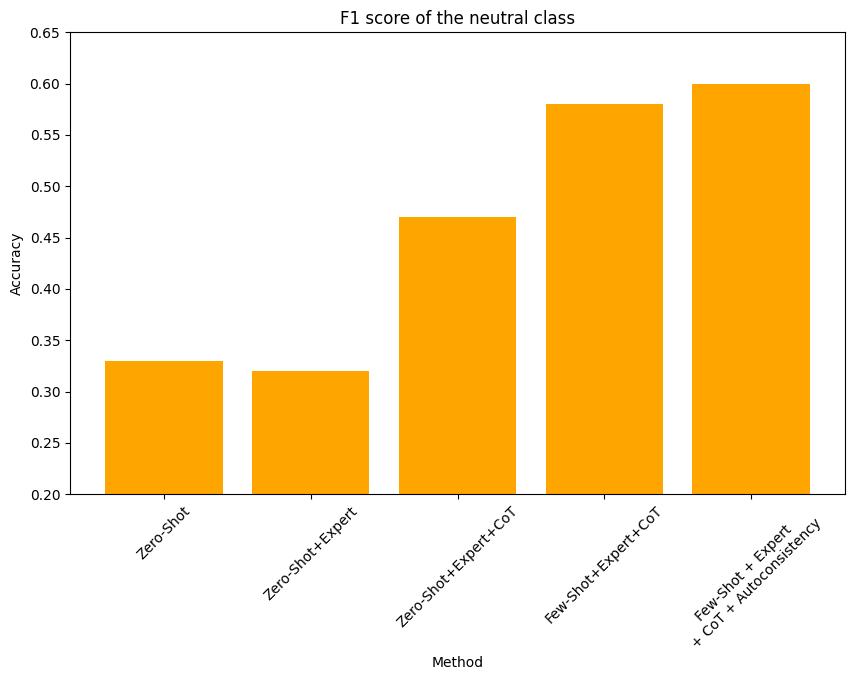

In [14]:
import matplotlib.pyplot as plt

# Labels for the x-axis
labels = ['Zero-Shot', 'Zero-Shot+Expert', 'Zero-Shot+Expert+CoT', 'Few-Shot+Expert+CoT', 'Few-Shot + Expert \n+ CoT + Autoconsistency']


# Creating the bar chart
plt.figure(figsize=(10, 6))
plt.bar(labels, f1_scores[:,1], color='orange')
plt.xlabel('Method')
plt.ylabel('Accuracy')
plt.title('F1 score of the neutral class')
plt.ylim(0.2, 0.65)  # Assuming accuracy is a percentage between 0 and 1
plt.xticks(rotation=45)  # Rotate labels to 45 degrees
plt.show()

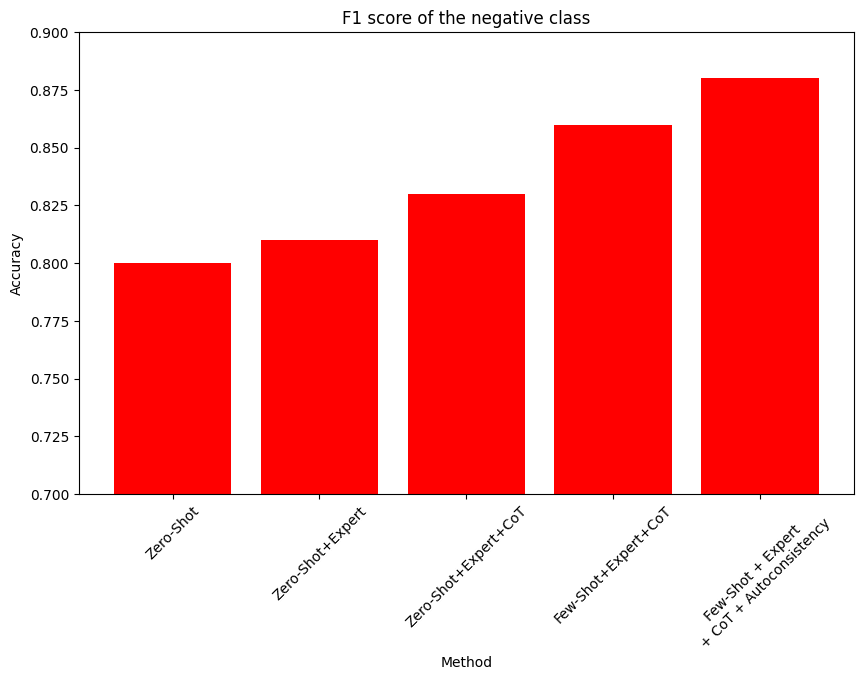

In [17]:
import matplotlib.pyplot as plt

# Labels for the x-axis
labels = ['Zero-Shot', 'Zero-Shot+Expert', 'Zero-Shot+Expert+CoT', 'Few-Shot+Expert+CoT', 'Few-Shot + Expert \n+ CoT + Autoconsistency']


# Creating the bar chart
plt.figure(figsize=(10, 6))
plt.bar(labels, f1_scores[:,0], color='red')
plt.xlabel('Method')
plt.ylabel('Accuracy')
plt.title('F1 score of the negative class')
plt.ylim(0.7, 0.9)  # Assuming accuracy is a percentage between 0 and 1
plt.xticks(rotation=45)  # Rotate labels to 45 degrees
plt.show()

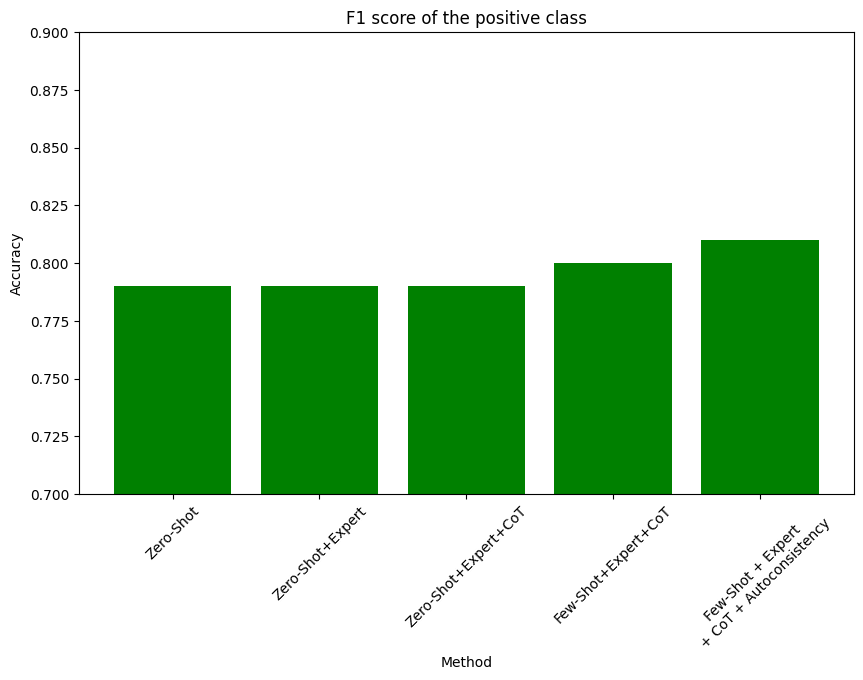

In [19]:
import matplotlib.pyplot as plt

# Labels for the x-axis
labels = ['Zero-Shot', 'Zero-Shot+Expert', 'Zero-Shot+Expert+CoT', 'Few-Shot+Expert+CoT', 'Few-Shot + Expert \n+ CoT + Autoconsistency']


# Creating the bar chart
plt.figure(figsize=(10, 6))
plt.bar(labels, f1_scores[:,2], color='green')
plt.xlabel('Method')
plt.ylabel('Accuracy')
plt.title('F1 score of the positive class')
plt.ylim(0.7, 0.9)  # Assuming accuracy is a percentage between 0 and 1
plt.xticks(rotation=45)  # Rotate labels to 45 degrees
plt.show()

In [3]:
import numpy as np
U = np.array([[0.46,0.2,-0.87],[-0.85,0.38,-0.37],[0.25,0.9,0.34]])
V = np.array([[0.46,-0.2,-0.87],[-0.85,-0.38,-0.37],[0.25,-0.9,0.34]])
T = np.array([[4.68,0,0],[0,2.83,0],[0,0,0.15]])
U@T@-V.T

array([[-0.990623,  1.996675,  0.01557 ],
       [ 1.996675, -2.993183,  1.98123 ],
       [ 0.01557 ,  1.98123 ,  1.98246 ]])

# Final Experiment
To get results over a larger data set and test GPT-4 we carried out a final experiment. 

+ **Data set:** 4000 reviews (balanced)

+ **Prompt:** We used Few-Shot + Expert + CoT. We did not use Autoconsistency due to the time and resource costliness of the experiment.

In [ ]:
import pandas as pd

# import the final dataset
df=pd.read_csv('./test_data_big.csv')

In [ ]:
from predicting_functions import *
import time 

#We are trying to bypass the API limitation, to get results for the whole data set
# Due to API limitations we predicted 100 reviews at a time and waited for a day when the maximum queries were made 

iterations=1
for i in range(1,40):
    print(i*100)
    df_copy=df[i*100:(i+1)*100]
    done = False
    while done==False:
        try:
            # Apply the prompting function
            predictions = df_copy['Review'].apply(lambda x: prompting(x, iterations = 1, shots = 'few',  model='gpt-4-1106-preview', explanation=True, confidence = True, role = 'expert hotelier' ,client=client))  
            # Iterate through each prediction and apply extract_class_confidence
            for j in range(iterations):
                # Assuming extract_class_confidence returns a single value or a tuple, adapt accordingly
                df_copy['prediction_' + str(j)] = predictions.apply(lambda x: extract_from_output(x[j], 'class'))
                df_copy['confidence_'+ str(j)] = predictions.apply(lambda x: extract_from_output(x[j], 'confidence_level'))

            save_string = 'predictions_' +str((i+1)*100) + '.csv'
            print('Saved: ',save_string)
            df_copy.to_csv(save_string) 
            done = True
        except Exception as e:
            print('Error occurred:', e)
            time.sleep(3600*24)

In [3]:
import pandas as pd
import os

# Directory where your CSV files are located
directory = './predictions/final/'

# Initialize an empty DataFrame to store the combined data
df = pd.DataFrame()

# Loop through the range of file numbers
for i in range(1, 41):
    file_path = os.path.join(directory, f'predictions_{i*100}.csv')
    # Check if the file exists
    if os.path.exists(file_path):
        # Read the CSV file
        temp_df = pd.read_csv(file_path)

        # Append the data to the combined DataFrame
        df = pd.concat([df, temp_df], ignore_index=True)


C:\Users\afred\AppData\Local\Temp\ipykernel_7864\2939891079.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[prediction_column]=df[prediction_column].str.lower()


Accuracy:  0.6713845924350661
              precision    recall  f1-score   support

           0       0.90      0.77      0.83      1565
           1       0.45      0.77      0.57       780
           2       0.95      0.76      0.85      1653

   micro avg       0.77      0.77      0.77      3998
   macro avg       0.77      0.77      0.75      3998
weighted avg       0.83      0.77      0.79      3998
 samples avg       0.77      0.77      0.77      3998



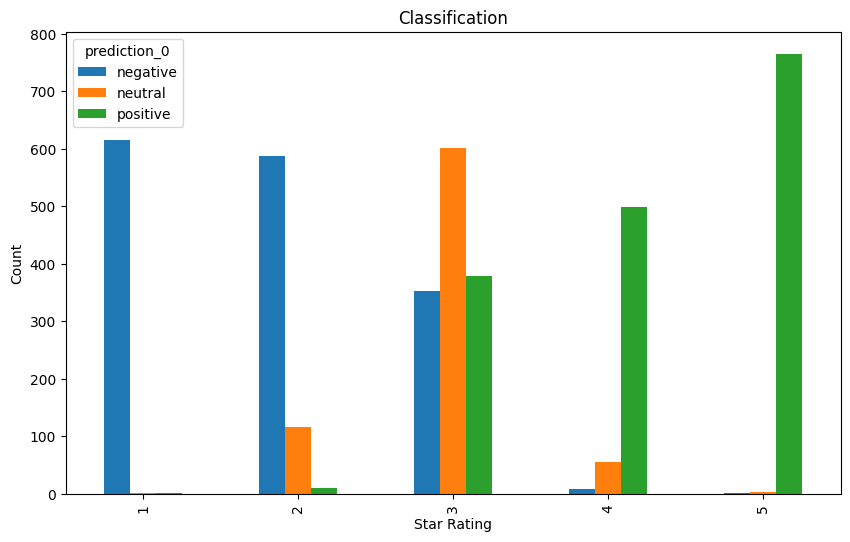

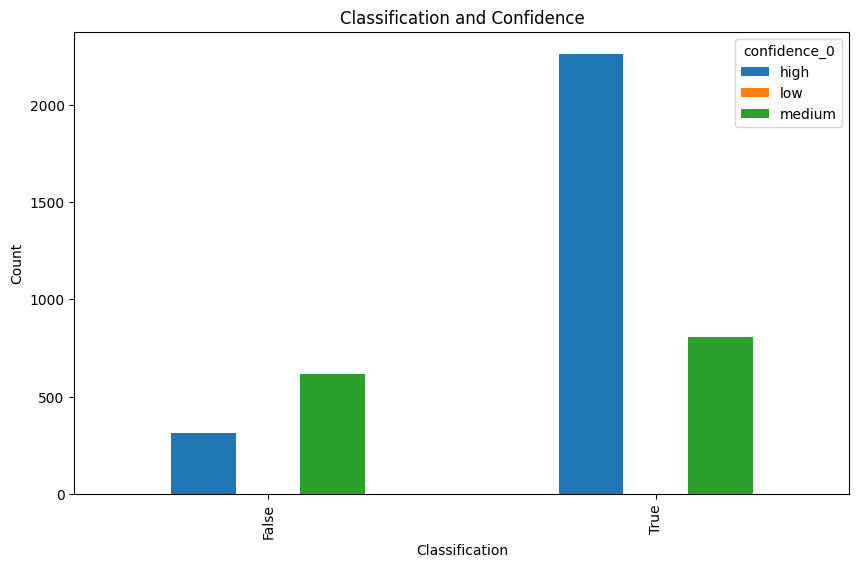

In [12]:
df, acc, rep = get_results_df(df,'prediction_0')
plot_results_df(df,'prediction_0')
plot_confidence(df,'confidence_0')